Begun 8/20/2024

Since we are seeing that the measured variance from simulations in pixell_sim_bincount_test_01_20240716 and pixell_sim_bincount_test_02_20240803 is not matching the theoretical curves well, I am going to replicate those results entirely in healpix to isolate the issue.

I will still use a realistic mask from the depth-1 maps. It can be ported over from a CAR map to a healpix map with pixell.reproject.map2healpix().

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pixell import enmap, enplot, reproject, utils, curvedsky
from tqdm import tqdm
import nawrapper as nw
import yaml
import time
import healpy as hp

In [2]:
# Loading in CAMB input spectra
ell_camb,DlTT_camb,DlEE_camb,DlBB_camb,DlTE_camb = np.loadtxt( \
            "/home/zbh5/act_analysis/act_axion_analysis/resources/camb_19413797_lensedtotcls.dat", \
                                                              usecols=(0,1,2,3,4), unpack=True) 
# Note that ell_camb runs from 2 to 5400
# Healpy expects ell to start at zero
# Initializing new arrays with first two entries set to zero
arr_len = ell_camb.size+2
ell = np.zeros(arr_len)
ell[1] = 1
ell[2:] = ell_camb
ClTT = np.zeros(arr_len)
ClEE = np.zeros(arr_len)
ClTE = np.zeros(arr_len)
ClBB = np.zeros(arr_len)
# convert Dl to Cl
ClTT[2:] = DlTT_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClEE[2:] = DlEE_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClTE[2:] = DlTE_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClBB[2:] = DlBB_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))

In [3]:
def make_tapered_mask(map_to_mask,filter_radius=1.0,plot=False):
    """
        Makes a mask for a given map based on where the ivar map is nonzero.
        Also apodizes the mask and gets the indices of where the apodized
        mask is not equal to one (everything tapered or outside the mask)
        in order to set all points but those to zero after filtering.
    """
    footprint = 1*map_to_mask.astype(bool)
    mask = nw.apod_C2(footprint,filter_radius)
    
    # Getting points to set to zero after filtering
    indices = np.nonzero(mask != 1)
    
    if plot:
        eshow(mask, **keys_eshow)
    
    return mask, indices

def get_hivon_fsky_enmap(mask):
    imap = mask/np.max(mask)
    w2w4 = (np.mean(imap**2.)**2./np.mean(imap**4.))
    skyarea = imap.area()/(4.*np.pi)*w2w4
    return skyarea

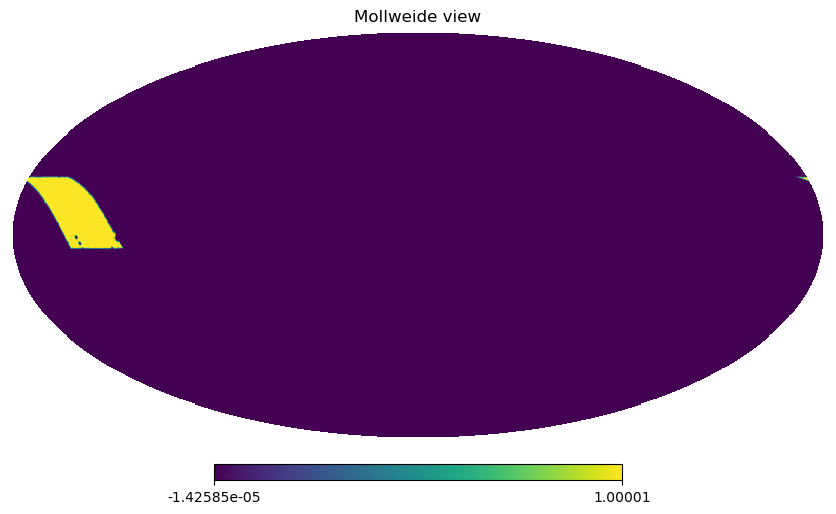

In [4]:
# Generating real depth-1 mask in healpix
obs_list = "/home/zbh5/act_analysis/dr6_analysis/dr6_depth1_maps/dr6_depth1_test_map_list.txt"
with open(obs_list) as f:
    lines = f.read().splitlines()

idx = 0
depth1_path = '/home/zbh5/act_analysis/dr6_analysis/dr6_depth1_maps/' + lines[idx]
ivar_path = depth1_path[:-8] + "ivar.fits"
depth1_ivar = 1.0*enmap.read_map(ivar_path) # 1.0 for T noise - shouldn't matter here; we just want the ivar shape
depth1_mask, depth1_indices = make_tapered_mask(depth1_ivar,filter_radius=1.0,plot=False)

healpy_mask = reproject.map2healpix(depth1_mask,nside=512)
hp.mollview(healpy_mask)

In [5]:
# Comparing w2 factors for pixell and healpix maps
print(np.mean(healpy_mask**2))
print(np.mean(depth1_mask**2))

# I think this difference only results from healpix maps being full sky while the depth-1 map is not

0.01357855062467451
0.33581580180667353


In [14]:
w2 = np.mean(healpy_mask**2)
w2w4 = np.mean(healpy_mask**2)**2 / np.mean(healpy_mask**4)

N_sims = 100
lmin = 50
lmax = 1000 # Need to use a smaller lmax due to our nside value
bin_size = 50
NSIDE = 512

bins = np.arange(lmin, lmax, bin_size)
centers = (bins[1:] + bins[:-1])/2.
print("Bin centers")
print(centers)

# binning CAMB input to match my spectra
digitized = np.digitize(ell[lmin:lmax], bins, right=True)
CAMB_ClTT_binned = np.bincount(digitized, ClTT[lmin:lmax].reshape(-1))[1:-1]/np.bincount(digitized)[1:-1]

spectra = []

for i in tqdm(range(N_sims)):
    alm = hp.sphtfunc.synalm(ClTT)
    input_map = hp.sphtfunc.alm2map(alm, nside=NSIDE, pol=False)
    full_spectrum = hp.sphtfunc.anafast(input_map*healpy_mask) / w2
    binned_spectrum = np.bincount(digitized, full_spectrum[lmin:lmax].reshape(-1))[1:-1]/np.bincount(digitized)[1:-1]
    spectra.append(binned_spectrum)
    
spectra = np.array(spectra)
variance = np.var(spectra,axis=0)
mean = np.mean(spectra, axis=0)

Bin centers
[ 75. 125. 175. 225. 275. 325. 375. 425. 475. 525. 575. 625. 675. 725.
 775. 825. 875. 925.]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:47<00:00,  2.27s/it]


In [17]:
f_sky = get_hivon_fsky_enmap(depth1_mask) # Fn. only works for a pixell map, but should give similar results regardless
theory_bincount_w_fsky = (2*centers + 1)*bin_size*w2 # Do we need a w2 both here and in theory_var?

theory_var = 2*CAMB_ClTT_binned**2/(theory_bincount_w_fsky*w2)
theory_var_w2w4 = 2*CAMB_ClTT_binned**2/(theory_bincount_w_fsky*w2w4)

print("Map name: " + lines[idx])
print("w2: " + str(w2))
print("w2w4: " + str(w2w4))
print("f_sky w/w2w4: " +str(f_sky))

Map name: depth1_1494463440_pa4_f150_map.fits
w2: 0.01357855062467451
w2w4: 0.013860558552060443
f_sky w/w2w4: 0.013837504089267325


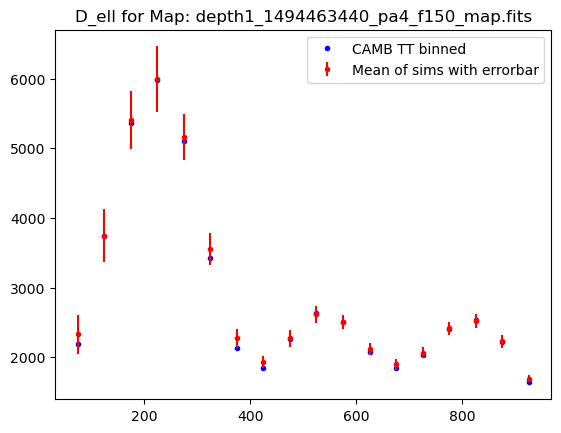

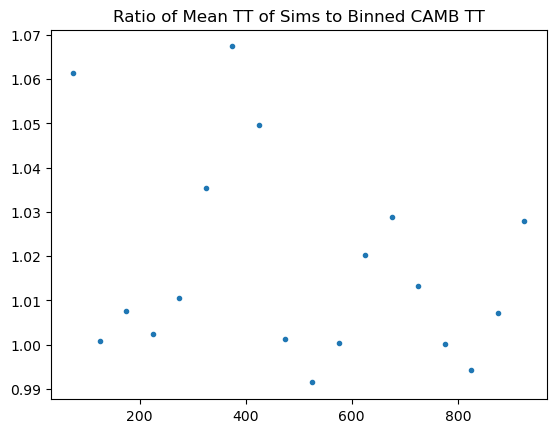

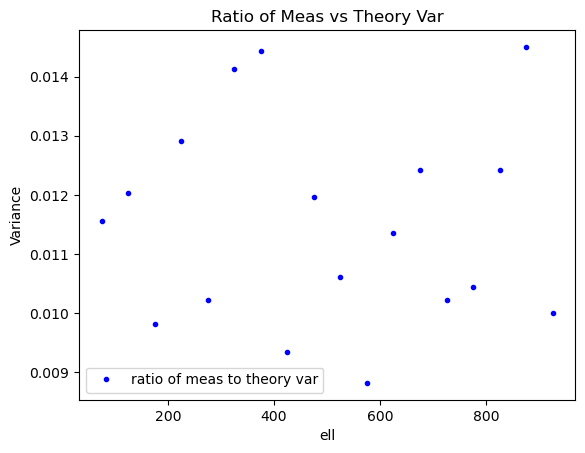

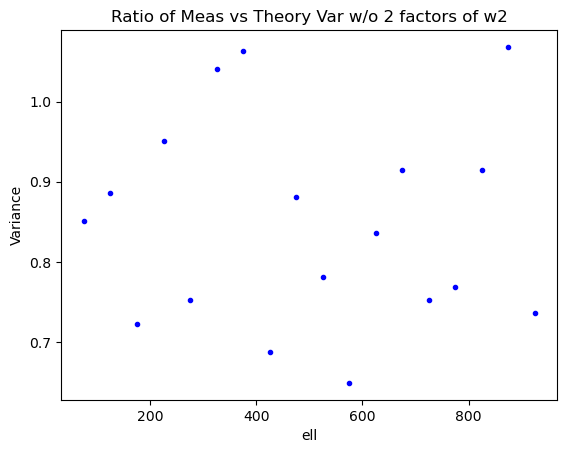

In [19]:
plt.plot(centers,centers*(centers+1)*CAMB_ClTT_binned/(2*np.pi),'b.',label='CAMB TT binned')
plt.errorbar(centers,centers*(centers+1)*mean/(2*np.pi),yerr=centers*(centers+1)*np.sqrt(variance)/(2*np.pi),fmt='r.',label='Mean of sims with errorbar')
plt.title("D_ell for Map: " + lines[idx])
plt.legend()
plt.show()
plt.close()

# Plotting the ratio of mean of sims to CAMB D_TT
plt.plot(centers,mean/CAMB_ClTT_binned,'.')
plt.title("Ratio of Mean TT of Sims to Binned CAMB TT")
plt.show()
plt.close()

plt.plot(centers,variance/theory_var,'b.',label='ratio of meas to theory var')
plt.legend()
plt.title("Ratio of Meas vs Theory Var")
plt.ylabel("Variance")
plt.xlabel("ell")
plt.show()
plt.close()

plt.plot(centers,variance/(w2*theory_var),'b.',label='ratio of meas to theory var')
plt.title("Ratio of Meas vs Theory Var w/o 2 factors of w2")
plt.ylabel("Variance")
plt.xlabel("ell")
plt.show()
plt.close()

In [9]:
# Redoing everything with no binning
w2 = np.mean(healpy_mask**2)
w2w4 = np.mean(healpy_mask**2)**2 / np.mean(healpy_mask**4)

N_sims = 100
lmin = 50
lmax = 1000 # Need to use a smaller lmax due to our nside value
NSIDE = 512

CAMB_ClTT_trimmed = ClTT[lmin:lmax]

spectra = []

for i in tqdm(range(N_sims)):
    alm = hp.sphtfunc.synalm(ClTT)
    input_map = hp.sphtfunc.alm2map(alm, nside=NSIDE, pol=False)
    spectrum = hp.sphtfunc.anafast(input_map*healpy_mask)[lmin:lmax] / w2
    spectra.append(spectrum)
    
spectra = np.array(spectra)
variance = np.var(spectra,axis=0)
mean = np.mean(spectra, axis=0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:37<00:00,  2.78s/it]


In [10]:
f_sky = get_hivon_fsky_enmap(depth1_mask) # Fn. only works for a pixell map, but should give similar results regardless
theory_bincount_w_fsky = (2*ell[lmin:lmax] + 1)*w2

theory_var = 2*CAMB_ClTT_trimmed**2/(theory_bincount_w_fsky*w2)
theory_var_w2w4 = 2*CAMB_ClTT_trimmed**2/(theory_bincount_w_fsky*w2w4)

print("Map name: " + lines[idx])
print("w2: " + str(w2))
print("w2w4: " + str(w2w4))
print("f_sky w/w2w4: " +str(f_sky))

Map name: depth1_1494463440_pa4_f150_map.fits
w2: 0.01357855062467451
w2w4: 0.013860558552060443
f_sky w/w2w4: 0.013837504089267325


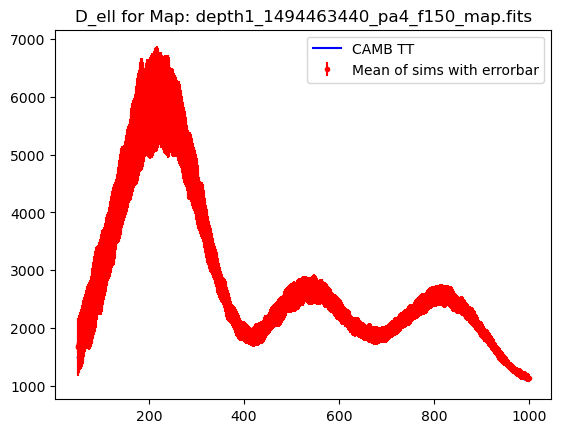

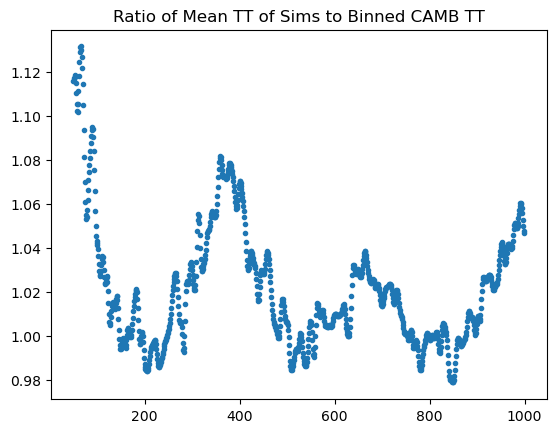

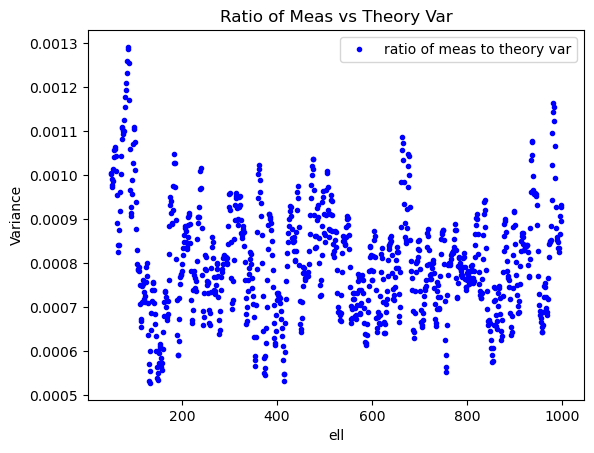

In [11]:
plt.plot(ell[lmin:lmax],ell[lmin:lmax]*(ell[lmin:lmax]+1)*CAMB_ClTT_trimmed/(2*np.pi),'b',label='CAMB TT')
plt.errorbar(ell[lmin:lmax],ell[lmin:lmax]*(ell[lmin:lmax]+1)*mean/(2*np.pi),yerr=ell[lmin:lmax]*(ell[lmin:lmax]+1)*np.sqrt(variance)/(2*np.pi),fmt='r.',label='Mean of sims with errorbar')
plt.title("D_ell for Map: " + lines[idx])
plt.legend()
plt.show()
plt.close()

# Plotting the ratio of mean of sims to CAMB D_TT
plt.plot(ell[lmin:lmax],mean/CAMB_ClTT_trimmed,'.')
plt.title("Ratio of Mean TT of Sims to Binned CAMB TT")
plt.show()
plt.close()

plt.plot(ell[lmin:lmax],variance/theory_var,'b.',label='ratio of meas to theory var')
plt.legend()
plt.title("Ratio of Meas vs Theory Var")
plt.ylabel("Variance")
plt.xlabel("ell")
plt.show()
plt.close()